# Milestone III.

Basic training and evaluation process

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
#import seaborn as sns
import numpy as np
import json
import pprint

In [70]:
"""
GLOVE DOWNLOAD (IF NECESSARY)
"""
# download glove (IT IS NOT NECESSARY IN THE DOCKER CONTAINER, GLOVE IS ALREADY DOWNLOADED THERE)
#!wget "http://nlp.stanford.edu/data/glove.6B.zip" -O temp.zip
#!unzip temp.zip -d glove
#!rm temp.zip
#root_path = ''

"""
ATTACH GLOVE FROM GOOGLE DRIVE (IF YOU HAVE IT)
"""
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Uni/msc_sem4/deeplearning'  #change dir to your project folder
#root_path = 'drive/My Drive/msc/dl_hf/' 

"""
IF GLOVE IS STORED IN THE GLOVE FOLDER
"""
# root_path = ''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'\nIF GLOVE IS STORED IN THE GLOVE FOLDER\n'

In [4]:
"""
DOWNLOAD DATA
"""
!mkdir data
!wget -c https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz -O - | tar -xz -C data

--2020-12-08 08:32:08--  https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz
Resolving smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)... 52.191.176.36
Connecting to smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13703288 (13M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  13.07M  3.79MB/s    in 3.4s    

2020-12-08 08:32:12 (3.79 MB/s) - written to stdout [13703288/13703288]



In [35]:
#NOTEBOOK CONTROL VARIABLES

# DO NOT MODIFY
# Model types
MODEL_BILSTM = "bilstm"
MODEL_LSTM = "lstm"

# Run mode
RUN_TESTMODE = "test" # train in 20000 data
RUN_FULLMODE = "full"
# END DO NOT MODIFY

# NOTEBOOK SETTINGS
MODEL_TYPE=MODEL_BILSTM
RUN_MODE=RUN_FULLMODE

# Attention layer, set true to include attention layer
ATTENTION_LAYER = True

HIDDEN_DIM = 128 # for lstm and bilstm mode
# Model fit parameters
BATCH_SIZE=32
EPOCHS=3
# Persist model
PERSIST_MODEL_AS = None # add a filename if you want to save the model at the end
# set False if the data needs to be downloaded
DATA_EXISTS=True

## Data preprocessing

In [7]:
import json

In [8]:
# load train dataset
train = []
with open("data/train.dataflow_dialogues.jsonl") as trainfile:
    content = trainfile.read()
    train = [json.loads(line) for line in content.splitlines()]

# load validation data
valid = []
with open("data/valid.dataflow_dialogues.jsonl") as validfile:
    content = validfile.read()
    valid = [json.loads(line) for line in content.splitlines()]

### Tokenization

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
# tokenized_lispress is an external function copied from 
# https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis
# Lispress is the program code to evaluate the answer to a user utturance
# The function tokenizes the lispress input string
from lispress_tokenizer import tokenized_lispress

In [10]:
# BOS and EOS indicate the beginning and ending of sentences
def tokenizeLispressWithEndings(dataset):
    '''
    Tokenizes lispress of each turn in the given dataset.
    The <bos> and <eos> tokens are appended to the token list.

    Returns nothing since it modifies the dataset
    '''
    for dialog in dataset:
        for turn in dialog["turns"]:
            turn['lispress_tokenized'] = ['<bos>'] + tokenized_lispress(turn['lispress']) + ['<eos>']

In [11]:
# separate Xpm Xam type string is user utterances

In [12]:
# create a tokenizer and fit on the sentences of the train data dialogues
tokenizer_user = Tokenizer()
dialogue_sent = [turn['user_utterance']['original_text'] for dialog in train for turn in dialog['turns'] ]
tokenizer_user.fit_on_texts(dialogue_sent)
# index of "the"
tokenizer_user.word_index["the"]

1

In [13]:
# create a tokenizer and fit on the tokenized lispress answers of the train data dialogues
lispress_tokenizer = Tokenizer()

# Tokenize lispress in train and valid according to a predefined logic
tokenizeLispressWithEndings(train)
tokenizeLispressWithEndings(valid)

# Tokenizer.fit_on_texts method can take list of list of strings as argument assuming the strings are tokens
dialogue_sent_lispress = [turn['lispress_tokenized'] for dialog in train for turn in dialog['turns']]
lispress_tokenizer.fit_on_texts(dialogue_sent_lispress)

In [14]:
# Example tokenized lispres
print(dialogue_sent_lispress[1])
print(lispress_tokenizer.word_counts['('])
print(lispress_tokenizer.word_index[')'])


['<bos>', '(', 'Yield', ':output', '(', ':dayOfWeek', '(', 'Tomorrow', ')', ')', ')', '<eos>']
1243286
2


In [15]:
def tokenizeDialogues(dataset,tokenizer):
    """
    Add a tokens2 attribute to the user_utterance in each turn with the token indexes
    Add a tokens2_readable attribute to the user_utterance with the readable tokens
    """
    for dialog in dataset:
        for turn in dialog['turns']:
            seq = tokenizer.texts_to_sequences([turn["user_utterance"]["original_text"]])[0]
            turn["user_utterance"].update({"tokens2":seq,"tokens2_readable":[tokenizer.index_word[index] for index in seq]})
            if "tokens2_variable_readable" in turn["user_utterance"]:
                del turn["user_utterance"]["tokens2_variable_readable"]
    tokenizedSet = [[ turn['user_utterance']['tokens2'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenizedSet,dataset

def tokenizeLispress(dataset,tokenizer):
    """
    Adds lispress_tokens attribute in each turn which stores the indices of the lispress tokens
    Adds lispress_tokens_readable attribute in each turn which stores the readable tokenized lispress
    """
    for dialog in dataset:
        for turn in dialog['turns']:
            seq = tokenizer.texts_to_sequences([turn["lispress_tokenized"]])[0]
            turn.update({"lispress_tokens":seq,"lispress_tokens_readable":[tokenizer.index_word[index] for index in seq]})
            if "lispress_tokens_variable_readable" in turn:
                del turn["lispress_tokens_variable_readable"]
    tokenizedSet = [[ turn['lispress_tokens'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenizedSet,dataset

In [16]:
# Tokenize the user utterance (request) in train and validation set
train_tokenized,train = tokenizeDialogues(train,tokenizer=tokenizer_user)
valid_tokenized,valid = tokenizeDialogues(valid,tokenizer=tokenizer_user)

In [17]:
# Tokenize the lispress (response) in train and validation set
train_tokenized_lispress,train_lispress = tokenizeLispress(train,tokenizer=lispress_tokenizer)
valid_tokenized_lispress,valid_lispress = tokenizeLispress(valid,tokenizer=lispress_tokenizer)

In [18]:
def add_parameters(train,train_lispress):
    variable_types = set()

    for di,dialogue in enumerate(train_lispress):
        for ti,turn in enumerate(dialogue["turns"]):
            var_idx={}
            for i,token in enumerate(turn["lispress_tokens_readable"]):
                if not "lispress_tokens_variable_readable" in turn:
                    turn.update({"lispress_tokens_variable_readable": list(turn["lispress_tokens_readable"])})
                if not "tokens2_variable_readable" in train[di]["turns"][ti]["user_utterance"]:
                    train[di]["turns"][ti]["user_utterance"].update({"tokens2_variable_readable":list(train[di]["turns"][ti]["user_utterance"]["tokens2_readable"])})
                if token == "#":
                    variable_expression = turn["lispress_tokens_readable"][i:turn["lispress_tokens_readable"].index(')',i)+1]
                    variable = []
                    var_type = variable_expression[2]
                    variable_types.add(var_type)
                    first = 0
                    last = -1
                    try:
                        first_index = variable_expression.index('"')
                        first = 4
                        last = -2
                    except:
                        first = 3
                        last=-1

                    variable = variable_expression[first:last]

                    for vi,var in enumerate(variable):
                        if var_type == "number":
                            try:
                                var = str(int(float(var)))
                            except Exception as e:
                                print(e)
                        # replace in user utterance
                        if var in train[di]["turns"][ti]["user_utterance"]["tokens2_readable"]:
                            if var_type not in var_idx:
                                var_idx.update({var_type:0})
                                placeholder = "<"+var_type+str(var_idx[var_type])+">"
                                var_idx[var_type]+=1
                                user_idx = train[di]["turns"][ti]["user_utterance"]["tokens2_readable"].index(var)
                                train[di]["turns"][ti]["user_utterance"]["tokens2_variable_readable"][user_idx] = placeholder
                                turn["lispress_tokens_variable_readable"][i+first+vi] = placeholder
                        else:
                            if var_type == "number":
                                for postfix in ["pm","am","th","st","nd"]:
                                    if var+postfix in train[di]["turns"][ti]["user_utterance"]["tokens2_readable"]:
                                        if var_type not in var_idx:
                                            var_idx.update({var_type:0})
                                            placeholder = "<"+var_type+str(var_idx[var_type])+">"
                                            var_idx[var_type]+=1
                                            user_idx = train[di]["turns"][ti]["user_utterance"]["tokens2_readable"].index(var+postfix)
                                            train[di]["turns"][ti]["user_utterance"]["tokens2_variable_readable"][user_idx] = placeholder+postfix
                                            turn["lispress_tokens_variable_readable"][i+first+vi] = placeholder
                            else:
                              pass
                                #print("not found in user utterance:",var,var_type,train[di]["turns"][ti]["user_utterance"]["tokens2_readable"])
                  #print("type:",var_type,"value:",variable)
                  #print("asd")


        #print(turn["lispress_tokens_variable_readable"])
        #print(train[di]["turns"][ti]["user_utterance"]["tokens2_variable_readable"])
    return train, train_lispress, variable_types

In [19]:
train_params,train_lispress_params,variable_types = add_parameters(train,train_lispress)


In [20]:
valid_params, valid_lispress_params, _ = add_parameters(valid,valid_lispress)

In [21]:
# example: tokens generated from a message
print("message:",train[0]["turns"][0]["user_utterance"]["original_text"])
print("tokens:",train[0]["turns"][0]["user_utterance"]["tokens2"])
print("readable tokens:",train[0]["turns"][0]["user_utterance"]["tokens2_readable"])
print("lispress tokens:",valid[0]["turns"][0]["lispress_tokens"])
print("lispress tokens readable:",valid[0]["turns"][2]["lispress_tokens_readable"])

print("lispress tokens with variables readable:",train_params[1]["turns"][0]["lispress_tokens_readable"])
print("lispress tokens with variables readable:",train_params[1]["turns"][0]["lispress_tokens_variable_readable"])

print("lispress tokens with variables readable:",train_params[1]["turns"][0]["user_utterance"]["tokens2_readable"])
print("lispress tokens with variables readable:",train_params[0]["turns"][0]["user_utterance"]["tokens2_variable_readable"])

message: what date is tomorrow?
tokens: [18, 101, 12, 22]
readable tokens: ['what', 'date', 'is', 'tomorrow']
lispress tokens: [5, 1, 7, 8, 1, 29, 12, 1, 30, 10, 1, 9, 34, 1, 62, 1, 40, 33, 1, 14, 11, 1, 17, 1, 21, 1, 27, 10, 1, 25, 2, 26, 4, 1, 28, 3, 550, 3, 2, 2, 2, 2, 2, 2, 1, 40, 33, 1, 14, 11, 1, 17, 1, 21, 1, 27, 10, 1, 25, 2, 26, 4, 1, 28, 3, 191, 3, 2, 2, 2, 2, 2, 2, 2, 78, 1, 13, 1, 89, 4, 1, 15, 58, 2, 2, 2, 74, 1, 13, 4, 1, 59, 3, 211, 423, 1095, 3, 2, 2, 18, 1, 13, 1, 45, 16, 1, 44, 41, 4, 1, 38, 3, 122, 3, 2, 2, 22, 1, 42, 32, 4, 1, 15, 99, 2, 2, 2, 2, 19, 1, 13, 4, 1, 20, 3, 500, 3, 2, 2, 2, 2, 2, 2, 6]
lispress tokens readable: ['<bos>', '(', 'yield', ':output', '(', 'createcommiteventwrapper', ':event', '(', 'createpreflighteventwrapper', ':constraint', '(', 'constraint[event]', ':attendees', '(', 'andconstraint', '(', 'andconstraint', '(', 'attendeelisthasrecipient', ':recipient', '(', 'execute', ':intension', '(', 'refer', '(', 'extensionconstraint', '(', 'recipientw

In [22]:
# user tokenizer on the parameterized input
user_tokenizer_params = Tokenizer()
dialogue_sent = [turn['user_utterance']['tokens2_variable_readable'] for dialog in train_params for turn in dialog['turns'] ]
user_tokenizer_params.fit_on_texts(dialogue_sent)
# lispress tokenizer on the parameterized programs
lispress_tokenizer_params = Tokenizer()
dialogue_sent_lispress_params = [turn['lispress_tokens_variable_readable'] for dialog in train_params for turn in dialog['turns']]
lispress_tokenizer_params.fit_on_texts(dialogue_sent_lispress_params)

In [23]:
lispress_tokenizer_params.word_index["<bos>"]

5

In [24]:
def tokenizer_with_params(dataset,user_tokenizer,lispress_tokenizer):
    for dialog in dataset:
        for turn in dialog['turns']:
            turn["user_utterance"].update({"tokens2_variable":[user_tokenizer.word_index[word] if word in user_tokenizer.word_index else 0 for word in turn["user_utterance"]["tokens2_variable_readable"]]})
            turn.update({"lispress_tokens_variable":[lispress_tokenizer.word_index[word] if word in lispress_tokenizer.word_index else 0 for word in turn["lispress_tokens_variable_readable"]]})
    tokenized_train = [[ turn['user_utterance']['tokens2_variable'] for turn in dialog['turns'] ]for dialog in dataset]
    tokenized_lispress = [[ turn['lispress_tokens_variable'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenized_train,tokenized_lispress

In [25]:
train_tokenized,train_tokenized_lispress = tokenizer_with_params(train_params,user_tokenizer_params,lispress_tokenizer_params)
valid_tokenized,valid_tokenized_lispress = tokenizer_with_params(valid_params,user_tokenizer_params,lispress_tokenizer_params)

In [26]:
def flatten_nested_list(list0):
    """
    Flatten the nested list's elements
    Example:
    [[1,2],[3]] => [1,2,3]
    """
    return [element for nested in list0 for element in nested ]

### Create train,validation,test data

In [36]:
if RUN_MODE == RUN_FULLMODE:

    MAX_TRAIN_DATA=-1 #how many train data will be used from the training set
    MAX_VALID_DATA=-100 # the last 99 elements of the validation data will be used as test data
    MAX_TEST_DATA=99

elif RUN_MODE == RUN_TESTMODE:
    MAX_TRAIN_DATA=20000 #limited training mode with 10000 data
    MAX_VALID_DATA=2000 # the last 99 elements of the validation data will be used as test data
    MAX_TEST_DATA=99

In [28]:
from copy import deepcopy
def create_previous_program_input(data):
    """
    from each dealogue -> remove the last element, and add a 0 to the beginning
    """
    data_tmp = deepcopy(data)
    for seqs in data_tmp:
        del seqs[-1]
        seqs.insert(0,[0])
    return data_tmp

In [54]:
# the user messages
train_data = flatten_nested_list(train_tokenized)[:MAX_TRAIN_DATA]
valid_data = flatten_nested_list(valid_tokenized)[:MAX_VALID_DATA]
test_data = flatten_nested_list(valid_tokenized)[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]

#the program stored in the last dialogue turn -> currently they are not taken into account
train_data_di = flatten_nested_list(create_previous_program_input(train_tokenized_lispress))[:MAX_TRAIN_DATA]
valid_data_di = flatten_nested_list(create_previous_program_input(valid_tokenized_lispress))[:MAX_VALID_DATA]
test_data_di = flatten_nested_list(create_previous_program_input(valid_tokenized_lispress))[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]

#the current program
train_data_y = flatten_nested_list(train_tokenized_lispress)[:MAX_TRAIN_DATA]
valid_data_y = flatten_nested_list(valid_tokenized_lispress)[:MAX_VALID_DATA]
test_data_y = flatten_nested_list(valid_tokenized_lispress)[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]


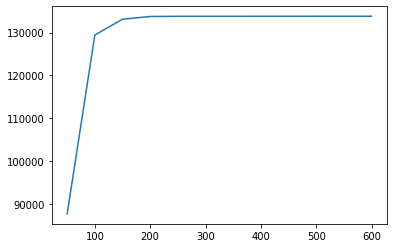

In [55]:
lens = []
for l in [50,100,150,200,250,600]:
  lens.append(len([x for x in train_data_y if len(x) < l]))
plt.plot([50,100,150,200,250,600],lens)

train_ids = [idx for idx,x in enumerate(train_data_y) if len(x) < 100]
valid_ids = [idx for idx,x in enumerate(valid_data_y) if len(x) < 100]
test_ids = [idx for idx,x in enumerate(test_data_y) if len(x) < 100]

In [56]:
print(len(train_ids),len(valid_ids),len(test_ids))

129436 14171 93


In [57]:
train_data = [x for idx,x in enumerate(train_data) if idx in train_ids]
valid_data = [x for idx,x in enumerate(valid_data) if idx in valid_ids]
test_data = [x for idx,x in enumerate(test_data) if idx in test_ids]

#the program stored in the last dialogue turn -> currently they are not taken into account
train_data_di = [x for idx,x in enumerate(train_data_di) if idx in train_ids]
valid_data_di = [x for idx,x in enumerate(valid_data_di) if idx in valid_ids]
test_data_di = [x for idx,x in enumerate(test_data_di) if idx in test_ids]

#the current program
train_data_y = [x for idx,x in enumerate(train_data_y) if idx in train_ids]
valid_data_y = [x for idx,x in enumerate(valid_data_y) if idx in valid_ids]
test_data_y = [x for idx,x in enumerate(test_data_y) if idx in test_ids]

In [58]:
# the length of the decoder input and output
MAX_LEN_DEC=max([len(i) for i in train_data_y])
print(MAX_LEN_DEC)

MAX_LEN_ENC=max([len(i) for i in train_data])
print(MAX_LEN_ENC)

99
104


In [50]:
len(train_data)

130273

In [59]:


# generate encoder input, decoder input and decoder target sequences
def generate_dataset(encoder_input,previous_program,current_program):
    """
    Creates the encoder input, decoder input and decoder output.
    For each target program create len(program)-1 training data:
    #   |Encoder input | Decoder input | Decoder output
    1.  |input sequence 1 | current program 1 first token | current program 1 second token
    2.  |input sequence 1 | current program 1 first two tokens | current program 1 2. and 3. tokens
    ...
    n.  |input sequence 1 | current program 1 n-MAX_LEN_DEC-1 -> n-1 tokens | current program 1 n-MAX_LEN_DEC -> n tokens
    n+1.|input sequence 2 | ...
    
    Parameters:
    encoder_input (list): list of input sequences
    previous_program (list): list of previous programs
    current_program (list): list of current programs (target)

    Returns:
    data: generated encoder input
    data_di: generated decoder input
    data_y: generated decoder output
    """
    data,data_di,data_y = [],[],[]
    for i,sent in enumerate(current_program):
        data.append(encoder_input[i])
        data_di.append(current_program[i])
        data_y.append(current_program[i][1:])
    return data,data_di,data_y

In [60]:
train_data_new,train_data_new_di,train_data_new_y = None,None,None
valid_data_new,valid_data_new_di,valid_data_new_y = None,None,None
test_data_new,test_data_new_di,test_data_new_y = None,None,None

In [61]:
# generate the training data
train_data_new,train_data_new_di,train_data_new_y = generate_dataset(train_data,train_data_di,train_data_y)
valid_data_new,valid_data_new_di,valid_data_new_y = generate_dataset(valid_data,valid_data_di,valid_data_y)
test_data_new,test_data_new_di,test_data_new_y = generate_dataset(test_data,test_data_di,test_data_y)

In [62]:
train_data_new[:10]

[[22, 104, 16, 25],
 [22, 51, 45, 1, 44, 16, 25],
 [28, 150, 36],
 [22, 43, 16, 10, 37, 9, 6, 422, 11, 14],
 [18, 15, 30, 41, 37, 9, 6, 422, 8, 7, 39],
 [4, 42, 20, 3, 70, 7, 89],
 [48, 55],
 [18, 15, 889, 2, 9, 6, 21, 188, 162],
 [739, 1, 401, 145, 38, 2, 112, 21, 158, 6],
 [30, 430, 122, 3932, 6, 2502, 503, 468, 393, 350]]

In [63]:
train_data_new_di[:1]

[[5, 1, 7, 8, 1, 64, 2, 2, 6]]

In [64]:
train_data_new_y[:1]

[[1, 7, 8, 1, 64, 2, 2, 6]]

### Padding encoder and decoder inputs, and decoder output

In [65]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [66]:
MAX_LEN=MAX_LEN_ENC # length of the encoder input

# padding the encoder, and decoder inputs
# padding will be added to the end of the encoder input (if needed)
# padding will be added to the begining of the decoder inputs and outputs (if needed)

encoder_train = pad_sequences(train_data_new,maxlen=MAX_LEN_ENC,dtype="int32",padding='post', truncating='post')
decoder_train = pad_sequences(train_data_new_y,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')
decoder_train_input = pad_sequences(train_data_new_di,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')

encoder_valid = pad_sequences(valid_data_new,maxlen=MAX_LEN_ENC,dtype="int32",padding='post', truncating='post')
decoder_valid = pad_sequences(valid_data_new_y,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')
decoder_valid_input = pad_sequences(valid_data_new_di,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')

encoder_test = pad_sequences(test_data_new,maxlen=MAX_LEN_ENC,dtype="int32",padding='post', truncating='post')
decoder_test = pad_sequences(test_data_new_y,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')
decoder_test_input = pad_sequences(test_data_new_di,maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')

### Create embedding matrices for the embedding layers

In [67]:
import os
import numpy as np

In [72]:
# load the glove vector representations
GLOVE_DIR="glove"
embeddings_index = {}
with open(os.path.join(root_path,GLOVE_DIR,"glove.6B.100d.txt"),'rb') as f:
    for line in f.readlines():
        values = line.split()
        word = str(values[0],encoding="utf8")
        coefs = np.asanyarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [73]:
# create embedding matrix for the encoder
embedding_dimension = 100
DECODING_DEPTH = len(lispress_tokenizer.word_index)+1
embedding_matrix_encoder = np.zeros((len(tokenizer_user.word_index)+1,embedding_dimension))
for word, i in tokenizer_user.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_encoder[i] = embedding_vector

# create embedding matrix for the decoder
embedding_matrix_decoder = np.zeros((DECODING_DEPTH,embedding_dimension))
for word, i in lispress_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < DECODING_DEPTH:
        embedding_matrix_decoder[i] = embedding_vector

In [74]:
def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):  
    """
    Creates the one hot encoded version of the data
    """
    decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

    for i, seqs in enumerate(decoder_input_data):
        for j, seq in enumerate(seqs):
            if j > 0 and seq < VOCAB_SIZE:
                decoder_output_data[i][j][seq] = 1.

    return decoder_output_data

### Create seq2seq model

Simple sequence to sequence model with LSTM encoder and decoder

In [75]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding,Dense,Activation,Concatenate,Bidirectional
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization

In [76]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints



class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     name='{}_b'.format(self.name),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
        #return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim
        #return input_shape[0], input_shape[1],input_shape[-1]

In [77]:
def dot_product(x, kernel):
   if K.backend() == 'tensorflow':
       return K.squeeze(K.dot(x, K.expand_dims(kernel)),axis=-1)
   else:
       return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
Attention operation, with a context/query vector, for temporal data.

"Hierarchical Attention Networks for Document Classification"
by using a context vector to assist the attention
# Input shape
    3D tensor with shape: (samples, steps, features).
# Output shape
    2D tensor with shape: (samples, features).
How to use:
Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
The dimensions are inferred based on the output shape of the RNN.
Note: The layer has been tested with Keras 2.0.6
Example:
    model.add(LSTM(64, return_sequences=True))
    model.add(AttentionWithContext())
    # next add a Dense layer (for classification/regression) or whatever
     """

def __init__(self,
             W_regularizer=None, u_regularizer=None, b_regularizer=None,
             W_constraint=None, u_constraint=None, b_constraint=None,
             bias=True, **kwargs):

    self.supports_masking = True
    self.init = initializers.get('glorot_uniform')

    self.W_regularizer = regularizers.get(W_regularizer)
    self.u_regularizer = regularizers.get(u_regularizer)
    self.b_regularizer = regularizers.get(b_regularizer)

    self.W_constraint = constraints.get(W_constraint)
    self.u_constraint = constraints.get(u_constraint)
    self.b_constraint = constraints.get(b_constraint)

    self.bias = bias
    super(AttentionWithContext, self).__init__(**kwargs)

def build(self, input_shape):
    assert len(input_shape) == 3

    self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                             initializer=self.init,
                             name='{}_W'.format(self.name),
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint)
    if self.bias:
        self.b = self.add_weight((input_shape[-1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name),
                                 regularizer=self.b_regularizer,
                                 constraint=self.b_constraint)

    self.u = self.add_weight((input_shape[-1],),
                             initializer=self.init,
                             name='{}_u'.format(self.name),
                             regularizer=self.u_regularizer,
                             constraint=self.u_constraint)

    super(AttentionWithContext, self).build(input_shape)

def compute_mask(self, input, input_mask=None):
    # do not pass the mask to the next layers
    return None

def call(self, x, mask=None):
    uit = dot_product(x, self.W)

    if self.bias:
        uit += self.b

    uit = K.tanh(uit)
    ait = dot_product(uit, self.u)

    a = K.exp(ait)

    # apply mask after the exp. will be re-normalized next
    if mask is not None:
        # Cast the mask to floatX to avoid float64 upcasting in theano
        a *= K.cast(mask, K.floatx())

    # in some cases especially in the early stages of training the sum may be almost zero
    # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
    # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
    a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

    a = K.expand_dims(a)
    weighted_input = x * a
    return K.sum(weighted_input, axis=1)

def compute_output_shape(self, input_shape):
    return input_shape[0], input_shape[-1]

In [78]:
def create_lstm_model(hidden_dim=128):
    embedding_dimension=100

    #create encoder embedding layer
    encoder_inputs = Input(shape=(MAX_LEN_ENC, ),dtype="int32")
    encoder_embedding = Embedding(input_dim = num_encoder_tokens,
                                output_dim = embedding_dimension,
                                input_length = MAX_LEN_ENC,
                                weights = [embedding_matrix_encoder],
                              trainable = False)(encoder_inputs)
    #create encoder lstm layer
    encoder_LSTM = LSTM(hidden_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

    #create decoder embedding layer
    decoder_inputs = Input(shape=(MAX_LEN_DEC, ),dtype="int32")
    decoder_embedding = Embedding(input_dim = DECODING_DEPTH,
                                output_dim = embedding_dimension,
                                input_length = MAX_LEN_DEC,
                                weights = [embedding_matrix_decoder],
                              trainable = False)(decoder_inputs)
    #create decoder LSTM layer using the encoder states
    decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])

    if ATTENTION_LAYER:
      decoder_outputs = Attention(MAX_LEN_DEC)(decoder_LSTM[0])
    else:
      decoder_outputs, _, _ = decoder_LSTM

    #output time distributed dense layer with softmax activation
    outputs = TimeDistributed(Dense(DECODING_DEPTH, activation='softmax'))(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], outputs)

    return model

def create_bilstm_model(hidden_dim=128):
    embedding_dimension=100

    #create encoder embedding layer
    encoder_inputs = Input(shape=(MAX_LEN_ENC, ),dtype="int32")
    encoder_embedding = Embedding(input_dim = num_encoder_tokens,
                                output_dim = embedding_dimension,
                                input_length = MAX_LEN_ENC,
                                weights = [embedding_matrix_encoder],
                              trainable = False)(encoder_inputs)
    
    encoder_LSTM = Bidirectional(LSTM(hidden_dim, return_state=True), merge_mode="concat")

    encoder_outputs, forward_h, forward_c, backward_c, backward_h = encoder_LSTM(encoder_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    encoder_states = [forward_h, forward_c, backward_h, backward_c]
    #create encoder lstm layer
    #encoder_LSTM = LSTM(hidden_dim, return_state=True)
    #encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

    #create decoder embedding layer
    decoder_inputs = Input(shape=(MAX_LEN_DEC, ),dtype="int32")
    decoder_embedding = Embedding(input_dim = DECODING_DEPTH,
                                output_dim = embedding_dimension,
                                input_length = MAX_LEN_DEC,
                                weights = [embedding_matrix_decoder],
                              trainable = False)(decoder_inputs)

    decoder_LSTM = LSTM(hidden_dim*2, return_state=True, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])
    print(decoder_LSTM[0])    

    if ATTENTION_LAYER:
      decoder_outputs = AttentionWithContext(MAX_LEN_DEC)(decoder_LSTM[0])
    else:
      decoder_outputs, _, _ = decoder_LSTM

    #output time distributed dense layer with softmax activation
    outputs = TimeDistributed(Dense(DECODING_DEPTH, activation='softmax'))(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], outputs)

    return model

In [79]:
num_encoder_tokens = len(tokenizer_user.word_index)+1
num_decoder_tokens = len(lispress_tokenizer.word_index)+1

In [80]:
if MODEL_TYPE == MODEL_LSTM:
    model = create_lstm_model(HIDDEN_DIM)
elif MODEL_TYPE == MODEL_BILSTM:
    model = create_bilstm_model(HIDDEN_DIM)

Tensor("lstm_1/PartitionedCall:1", shape=(None, 99, 256), dtype=float32)


In [81]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 104, 100)     1629700     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 99)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 234496      embedding[0][0]                  
_______________________________________________________________________________________

In [82]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

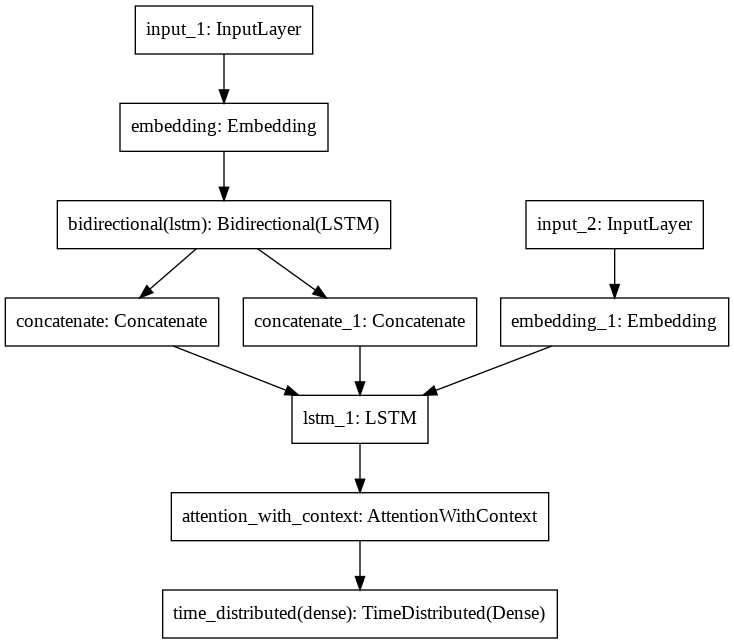

In [83]:
plot_model(model,show_layer_names=True)

In [85]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

## Training

In [86]:
# data generator for the training
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, input, batch_size=32, num_classes=None, shuffle=False):
        self.batch_size = batch_size
        self.input = input
        self.indices = list(range(len(input[0])))
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        #print(batch[0],batch[-1])
        encoder = np.array(self.input[0][batch[0]:batch[-1]+1])
        decoder = np.array(self.input[1][batch[0]:batch[-1]+1])
        X = [encoder,decoder]
        #print(X)
        y = decoder_output_creater(self.input[2][batch[0]:batch[-1]+1],len(batch),MAX_LEN_DEC,DECODING_DEPTH)

        return X, y


In [87]:
len(encoder_train)

129436

In [88]:
batch_size = BATCH_SIZE

model.fit(DataGenerator([encoder_train,decoder_train_input,decoder_train],batch_size=batch_size),
         batch_size=batch_size,epochs=EPOCHS,validation_data=DataGenerator([encoder_valid,decoder_valid_input,decoder_valid],batch_size=batch_size))

Epoch 1/3
4044/4044 [==============================] - 651s 161ms/step - loss: 0.4058 - accuracy: 0.9041 - val_loss: 0.1526 - val_accuracy: 0.9525
Epoch 2/3
4044/4044 [==============================] - 655s 162ms/step - loss: 0.1228 - accuracy: 0.9600 - val_loss: 0.1000 - val_accuracy: 0.9650
Epoch 3/3
4044/4044 [==============================] - 666s 165ms/step - loss: 0.0885 - accuracy: 0.9684 - val_loss: 0.0812 - val_accuracy: 0.9702


In [ ]:
if PERSIST_MODEL_AS is not None:
    model.save(os.path.join("models",PERSIST_MODEL_AS))

In [89]:
def extract_lispress_from_pred(pred,tokenizer):
    """
    Returns the lispress program and lispress token codes from the prediction
    """
    lines = []
    codes = []
    for p in pred:
        line = [tokenizer.index_word[np.argmax(vec)] if np.argmax(vec) > 0 else "UNKNOWN" for vec in p ]
        code = [np.argmax(vec) for vec in p ]
        #print(codes)
        lines.append(line)
        codes.append(code)
    return lines,codes

In [90]:
def make_prediction(sent,program,user_tokenizer,lispress_tokenizer,model,isText=True):
    """
    Makes prediction for a given sentence
    
    Method: the input of the encoder will be the given sentence in each turn; the decoder input will be first a <bos> token,
    we apply padding to shift the <bos> token to the end of the decoder input. Then we make a prediction, and concat the last token of the
    prediction to the previous decoder input. We repeat this until we gets an <eos> token or we reach the max length
    
    Parameters:
    sent (string|list): input code sequence or input text
    program: not used
    user_tokenizer
    lispress_tokenizer
    model
    isText (boolean): True if the input is text False else
    
    Returns the predicted lispress program (token codes)
    """
    if isText:
        seq = user_tokenizer.texts_to_sequences([sent])[0]
    else:
        seq = sent
    print("Question:", [user_tokenizer.index_word[code] if code in user_tokenizer.index_word else "unknown" for code in seq])
    decoder = ["<bos>"]
    length = 0
    MAX_LENGTH = 100
    decoder_seq = [lispress_tokenizer.word_index[word] for word in decoder]

    seq_pad = pad_sequences([seq],maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')[0]
    decoder_pad = pad_sequences([decoder_seq],maxlen=MAX_LEN_DEC,dtype="int32",padding='pre', truncating='pre')[0]

    line = [["asd"]]

    while length < MAX_LENGTH and line[0][-1] != '<eos>':
        pred = model.predict([np.array([seq_pad]),np.array([decoder_pad])])[0]
        line,code = extract_lispress_from_pred([pred],lispress_tokenizer)
        decoder_seq.append(code[0][-1])
        decoder_pad = pad_sequences([decoder_seq],maxlen=MAX_LEN_DEC,dtype="int32",padding='pre', truncating='pre')[0]
        length += 1

    print("Program:",[lispress_tokenizer.index_word[code0] if code0>0 else "UNKNOWN" for code0 in decoder_seq])  

    return decoder_seq

In [91]:
def make_prediction2(sent,program,user_tokenizer,lispress_tokenizer,model,isText=True):
    """
    Makes prediction for a given sentence
    
    Method: the input of the encoder will be the given sentence in each turn; the decoder input will be first a <bos> token,
    we apply padding to shift the <bos> token to the end of the decoder input. Then we make a prediction, and concat the last token of the
    prediction to the previous decoder input. We repeat this until we gets an <eos> token or we reach the max length
    
    Parameters:
    sent (string|list): input code sequence or input text
    program: not used
    user_tokenizer
    lispress_tokenizer
    model
    isText (boolean): True if the input is text False else
    
    Returns the predicted lispress program (token codes)
    """
    if isText:
        seq = user_tokenizer.texts_to_sequences([sent])[0]
    else:
        seq = sent
    print("Question:", [user_tokenizer.index_word[code] if code in user_tokenizer.index_word else "unknown" for code in seq])
    decoder = ["<bos>","(","yield",":output"]
    length = 4
    MAX_LENGTH = MAX_LEN_DEC
    decoder_seq = [lispress_tokenizer.word_index[word] for word in decoder]
    next_index = 3
    seq_pad = pad_sequences([seq],maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')[0]
    decoder_pad = pad_sequences([decoder_seq],maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')[0]

    line = [["asd","asd","asd","asd"]]
    last_token="asd"
    while length < MAX_LENGTH and last_token != '<eos>':
        #print(next_index)
        #print(length)
        pred = model.predict([np.array([seq_pad]),np.array([decoder_pad])])[0]
        line,code = extract_lispress_from_pred([pred],lispress_tokenizer)
        print(line[0])
        decoder_seq.append(code[0][next_index])
        last_token = line[0][next_index]
        #decoder_seq.append(code[0][-1])
        #print(decoder_seq)
        if code[0][next_index] == 0:
            break
        next_index+=1
        
        decoder_pad = pad_sequences([decoder_seq],maxlen=MAX_LEN_DEC,dtype="int32",padding='post', truncating='post')[0]
        length += 1
        #print(" ".join([lispress_tokenizer.index_word[code] for code in decoder_seq]))

    print("Program:",[lispress_tokenizer.index_word[code0] if code0>0 else "UNKNOWN" for code0 in decoder_seq])  

    return decoder_seq

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# load a model trained on the first 1 million data (if you want to skip the training part)
#model = load_model('models/model20201121_newtokenizer_50-50-1M.h5')
#model.save("models/model20201125_parameterized_fulllength_e14.h5")

## Evaluation

In [92]:
TP=0
ALL=0
for i,test in enumerate(test_data[:]):
    prediction = make_prediction2(test,[],user_tokenizer=user_tokenizer_params,lispress_tokenizer=lispress_tokenizer_params,model=model,isText=False)
    print("Expected:",[lispress_tokenizer_params.index_word[code] if code in lispress_tokenizer_params.index_word else "UNKNOWNCODE"  for code in test_data_y[i]])
    ALL+=1
    if len(prediction) == len(test_data_y[i]) and np.sum([ 0 if pred == expected else 1 for pred,expected in zip(prediction,test_data_y[i])] ) == 0:
        TP+=1
    print("Accuracy:",TP/ALL)

print("Accuracy:",TP/ALL)

Question: ['what', 'are', 'my', 'upcoming', 'appointments']
['(', 'yield', ':output', '(', '(', '(', '(', '(', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN'

In [93]:
print("Accuracy:",TP/ALL)

Accuracy: 0.24731182795698925
